In [2]:
from matplotlib import image
import matplotlib.pyplot as plt
import numpy as np

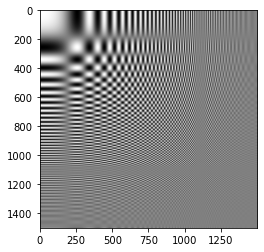

In [83]:
from scipy.signal import chirp, spectrogram

t = np.linspace(0, 10, 1500)

x = chirp(t, f0=0.1, f1=20, t1=10, method='quadratic')
y = chirp(t, f0=0.1, f1=20, t1=10, method='quadratic')
chirp_img = np.transpose([y]) @ [x]
plt.imshow(chirp_img, cmap='gray')
plt.imsave("chirp.png", chirp_img, cmap="gray")

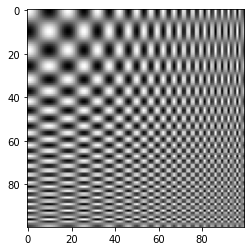

In [84]:
from scipy.signal import chirp, spectrogram

t = np.linspace(0, 10, 100)

x = chirp(t, f0=0.5, f1=4, t1=10, method='quadratic')
y = chirp(t, f0=0.5, f1=4, t1=10, method='quadratic')
chirp_small_img = np.transpose([y]) @ [x]
plt.imshow(chirp_small_img, cmap='gray')
plt.imsave("chirp_small.png", chirp_small_img, cmap="gray")

In [74]:
import math
from tqdm.notebook import tqdm


def bilinear(img, new_h, new_w):
    h, w = img.shape
    new_img = np.zeros((new_h, new_w))
    p_ys = np.linspace(0, h - 2, new_h) + 0.5
    p_xs = np.linspace(0, w - 2, new_w) + 0.5
    for y in tqdm(range(new_h)):
        for x in range(new_w):
            p_y = p_ys[y]
            p_x = p_xs[x]
            
            ly = math.floor(p_y)
            lx = math.floor(p_x)
            uy = ly + 1
            ux = lx + 1
            
            dy = p_y - ly
            dx = p_x - lx
            
            pixel = img[ly, lx] * (1 - dy) * (1 - dx)
            pixel += img[uy, lx] * (dy) * (1 - dx)
            pixel += img[ly, ux] * (1 - dy) * (dx)
            pixel += img[uy, ux] * (dy) * (dx)
            
            new_img[y, x] = pixel
    return new_img

In [97]:
def bicubic(arr, x, x0, x1):
    t = (x - x0) / (x1 - x0)
    return \
        (-0.5 * arr[0] + 1.5 * arr[1] - 1.5 * arr[2] + 0.5 * arr[3]) * t ** 3 + \
        (arr[0] - 2.5 * arr[1] + 2 * arr[2] - 0.5 * arr[3]) * t ** 2 + \
        (-0.5 * arr[0] + 0.5 * arr[2]) * t + \
        arr[1]

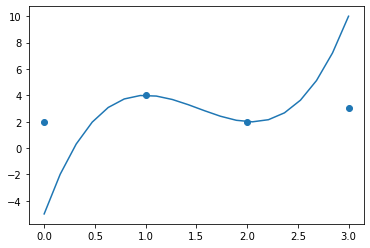

In [98]:
px = [0, 1, 2, 3]
py = [2, 4, 2, 3]
x = np.linspace(0, 3, 20)

plt.scatter(px, py)
plt.plot(x, bicubic(py, x, px[1], px[2]))

In [100]:
def bicubic_2d(arr, x, y, x0, y0, x1, y1):
    values = [
        bicubic(arr[0, :], x, x0, x1),
        bicubic(arr[1, :], x, x0, x1),
        bicubic(arr[2, :], x, x0, x1),
        bicubic(arr[3, :], x, x0, x1)
    ]
    return bicubic(values, y, y0, y1)

In [101]:
def bicubic_img(img, new_h, new_w):
    padded_img = np.pad(img, 1, 'edge')
    h, w = img.shape
    new_img = np.zeros((new_h, new_w))
    p_ys = np.linspace(0, h - 2, new_h) + 1.5
    p_xs = np.linspace(0, w - 2, new_w) + 1.5
    
    for y in tqdm(range(new_h)):
        for x in range(new_w):
            px = p_xs[x]
            py = p_ys[y]
            x1 = math.floor(px)
            y1 = math.floor(py)
            arr = padded_img[y1 - 1:y1 + 3, x1 - 1: x1 + 3]
            
            new_img[y, x] = bicubic_2d(arr, px, py, x1, y1, x1 + 1, y1 + 1)
    return new_img

In [ ]:
def bicubic(img, new_h, new_w):
    h, w = img.shape
    new_img = np.zeros((new_h, new_w))
    p_ys = np.linspace(0, h - 2, new_h) + 0.5
    p_xs = np.linspace(0, w - 2, new_w) + 0.5
    
    x_interps = np.zeros((h, new_w))
    for y in range(h):
        for x in range(new_w):
            px = p_xs[x]
            x1 = math.floor(px)
            x2 = x1 + 1
            y1 = img[y, x1]
            y2 = img[y, x2]
            y0 = y1
            y3 = y2
            if x1 > 0:
                y0 = img[y, x1 - 1]
            if x2 < w - 1:
                y3 = img[y, x2 + 1]
            x_interps[y, x] = bicubic_interpolate()

In [153]:
def sinc(img, new_h, new_w):
    r = 10
    stretch = 0.4
    h, w = img.shape
    new_img = np.zeros((new_h, new_w))
    p_ys = np.linspace(0, h - 2, new_h) + 0.5
    p_xs = np.linspace(0, w - 2, new_w) + 0.5
    
    for y in tqdm(range(new_h)):
        for x in range(new_w):
            px = p_xs[x]
            py = p_ys[y]
            ix = math.floor(px)
            iy = math.floor(py)
            
            total = 0
            
            for y1 in range(iy - r + 1, iy + r + 3):
                for x1 in range(ix - r + 1, ix + r + 3):
                    if y1 < 0 or x1 < 0 or y1 >= h or x1 >= w:
                        continue
                    total += stretch ** 2 * np.sinc(stretch * (x1 - px)) * np.sinc(stretch * (y1 - py)) * img[y1, x1]
            new_img[y, x] = total
    return new_img

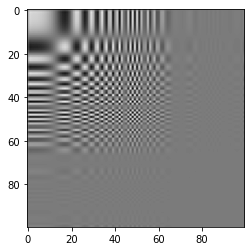

In [122]:
chirp_resized = sinc(chirp_img, 100, 100)
plt.imshow(chirp_resized, cmap="gray")
plt.imsave("chirp_shrink_sinc.png", chirp_resized, cmap="gray")

(587, 880)


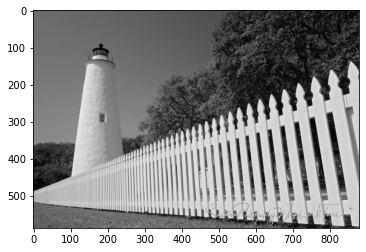

In [58]:
from PIL import Image, ImageOps

# load image as pixel array
og_image = Image.open("Lighthouse.JPG")
gray_image = ImageOps.grayscale(og_image)
lighthouse_img = np.array(gray_image)

print(lighthouse_img.shape)
plt.imshow(lighthouse_img, cmap="gray")

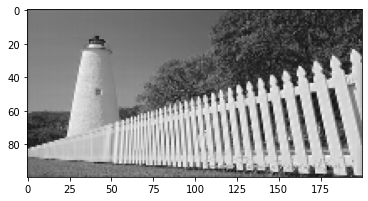

In [154]:
lighthouse_resized = sinc(lighthouse_img, 100, 200)
plt.imshow(lighthouse_resized, cmap="gray")
plt.imsave("lighthouse_shrink_sinc_2.png", lighthouse_resized, cmap="gray")

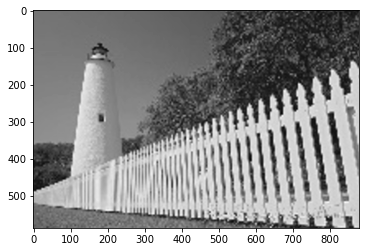

In [109]:
# load image as pixel array
og_image = Image.open("Lighthouse_small.jpg")
gray_image = ImageOps.grayscale(og_image)
lighthouse_small_img = np.array(gray_image)

lighthouse_resized = bicubic_img(lighthouse_small_img, 587, 880)
plt.imshow(lighthouse_resized, cmap="gray")
plt.imsave("lighthouse_magnify_bicubic.png", lighthouse_resized, cmap="gray")

In [145]:
s = 1.0
x = np.arange(-100, 100, s)
x += 0.5
y = np.sinc(x) * s
print(np.sum(y))

1.990997511755317


In [156]:
print(lighthouse_resized[11, 11])
print(lighthouse_small_img[11, 11])

108.96877159109594
109


In [6]:
total = 0
stretch = 0.4
for y1 in range(-10, 11):
    for x1 in range(-10, 11):
        total += np.sinc(stretch * (x1)) * np.sinc(stretch * (y1)) * stretch**2

print(total)

0.9154294978036848
